In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

Ссылка на датает:

https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/topic-pages/tables/table-1

Я немного исправил таблицу, поэтому скинул исправленный вариант вместе с ноутбуком.

In [2]:
!ls

FBI_crime_stats.xls  table-1.xls  Vasilyev_DB11.ipynb


In [3]:
crimes_data = pd.read_excel("FBI_crime_stats.xls")
crimes_data = crimes_data[:20]

In [4]:
crimes_data

,Year,Population,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate,Rape (revised definition),Rape (revised definition) rate,Rape (legacy definition),Rape (legacy definition) rate,...,Aggravated assault,Aggravated assault rate,Property crime,Property crime rate,Burglary,Burglary rate,Larceny-theft,Larceny-theft rate,Motor vehicle theft,Motor vehicle theft rate
0,1997.0,267783607.0,1636096.0,611,18208.0,6.8,NaN,NaN,96153.0,35.9,...,1023201.0,382.1,11558475.0,4316.3,2460526.0,918.8,7743760.0,2891.8,1354189.0,505.7
1,1998.0,270248003.0,1533887.0,567.6,16974.0,6.3,NaN,NaN,93144.0,34.5,...,976583.0,361.4,10951827.0,4052.5,2332735.0,863.2,7376311.0,2729.5,1242781.0,459.9
2,1999.0,272690813.0,1426044.0,523,15522.0,5.7,NaN,NaN,89411.0,32.8,...,911740.0,334.3,10208334.0,3743.6,2100739.0,770.4,6955520.0,2550.7,1152075.0,422.5
3,2000.0,281421906.0,1425486.0,506.5,15586.0,5.5,NaN,NaN,90178.0,32.0,...,911706.0,324.0,10182584.0,3618.3,2050992.0,728.8,6971590.0,2477.3,1160002.0,412.2
4,2001.0,285317559.0,1439480.0,504.5,16037.0,5.6,NaN,NaN,90863.0,31.8,...,909023.0,318.6,10437189.0,3658.1,2116531.0,741.8,7092267.0,2485.7,1228391.0,430.5
5,2002.0,287973924.0,1423677.0,494.4,16229.0,5.6,NaN,NaN,95235.0,33.1,...,891407.0,309.5,10455277.0,3630.6,2151252.0,747.0,7057379.0,2450.7,1246646.0,432.9
6,2003.0,290788976.0,1383676.0,475.8,16528.0,5.7,NaN,NaN,93883.0,32.3,...,859030.0,295.4,10442862.0,3591.2,2154834.0,741.0,7026802.0,2416.5,1261226.0,433.7
7,2004.0,293656842.0,1360088.0,463.2,16148.0,5.5,NaN,NaN,95089.0,32.4,...,847381.0,288.6,10319386.0,3514.1,2144446.0,730.3,6937089.0,2362.3,1237851.0,421.5
8,2005.0,296507061.0,1390745.0,469,16740.0,5.6,NaN,NaN,94347.0,31.8,...,862220.0,290.8,10174754.0,3431.5,2155448.0,726.9,6783447.0,2287.8,1235859.0,416.8
9,2006.0,299398484.0,1435123.0,479.3,17309.0,5.8,NaN,NaN,94472.0,31.6,...,874096.0,292.0,10019601.0,3346.6,2194993.0,733.1,6626363.0,2213.2,1198245.0,400.2


In [5]:
crimes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 22 columns):
Year                                         20 non-null float64
Population                                   20 non-null float64
Violent crime                                20 non-null float64
Violent crime rate                           20 non-null object
Murder and nonnegligent manslaughter         20 non-null float64
Murder and nonnegligent manslaughter rate    20 non-null float64
Rape (revised definition)                    4 non-null float64
Rape (revised definition) rate               4 non-null float64
Rape (legacy definition)                     20 non-null float64
Rape (legacy definition) rate                20 non-null float64
Robbery                                      20 non-null float64
Robbery rate                                 20 non-null float64
Aggravated assault                           20 non-null float64
Aggravated assault rate                      20 non-nul

### Первичный анализ данных

В данном датасете собрана статистика ФБР о преступлениях совешенных в США за период с 1997 по 2016 год. Преведены данные о численности населения США, об общем количестве преступлений и числе преступлений на 100000 человек следующих видов преступлений: насильственное преступление, убийство и непредумышленное убийство (вместе), изнасилование по старому и пересмотренному определению, ограбления, нападение, порча имущества, кража со взломом, воровство, угон. Все переменные имеют тип np.float64. Целью данного проекта является прогноз количества преступлений некоторых типов и выявление общий тенденции. Данные по изнасилованиям по пересмотренному определению собраны только за 2013 - 2016 (видимо, в 2013 определение как раз и было пересмотрено).

### Предобработка данных

Данных в колонках Rape (revised definition) и Rape (revised definition) rate недостаточно, поэтому удалим их таблицы.

In [6]:
crimes_data = crimes_data.drop(['Rape (revised definition)',
                                'Rape (revised definition) rate'],
                                axis=1)

Некоторые строки в колонках Violent crime rate Larceny-theft rate и имеют целочисленный тип. Приведем всю таблицу к одному типу float64. 

In [7]:
col_to_conv = ('Violent crime rate', 'Larceny-theft rate')

In [8]:
for col in col_to_conv:
    crimes_data[col] = pd.to_numeric(crimes_data[col])

Я собираюсь работать с общим числом преступлений, добавим соответствующие колонки Crimes sum и Crimes sum rate

In [9]:
crimes_sum = pd.Series([0 for i in range(20)])
crimes_sum_rate = pd.Series([0 for i in range(20)])
for col in crimes_data.columns[2::2]:
    crimes_sum += crimes_data[col]
for col in crimes_data.columns[3::2]:
    crimes_sum_rate += crimes_data[col]
crimes_data['Crimes sum'] = crimes_sum
crimes_data['Crimes sum rate'] = crimes_sum_rate

In [10]:
crimes_data.index = crimes_data['Year'].values.astype(int)

In [11]:
crimes_data

,Year,Population,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate,Rape (legacy definition),Rape (legacy definition) rate,Robbery,Robbery rate,...,Property crime,Property crime rate,Burglary,Burglary rate,Larceny-theft,Larceny-theft rate,Motor vehicle theft,Motor vehicle theft rate,Crimes sum,Crimes sum rate
1997,1997.0,267783607.0,1636096.0,611.0,18208.0,6.8,96153.0,35.9,498534.0,186.2,...,11558475.0,4316.3,2460526.0,918.8,7743760.0,2891.8,1354189.0,505.7,26389142.0,9854.6
1998,1998.0,270248003.0,1533887.0,567.6,16974.0,6.3,93144.0,34.5,447186.0,165.5,...,10951827.0,4052.5,2332735.0,863.2,7376311.0,2729.5,1242781.0,459.9,24971428.0,9240.4
1999,1999.0,272690813.0,1426044.0,523.0,15522.0,5.7,89411.0,32.8,409371.0,150.1,...,10208334.0,3743.6,2100739.0,770.4,6955520.0,2550.7,1152075.0,422.5,23268756.0,8533.1
2000,2000.0,281421906.0,1425486.0,506.5,15586.0,5.5,90178.0,32.0,408016.0,145.0,...,10182584.0,3618.3,2050992.0,728.8,6971590.0,2477.3,1160002.0,412.2,23216140.0,8249.6
2001,2001.0,285317559.0,1439480.0,504.5,16037.0,5.6,90863.0,31.8,423557.0,148.5,...,10437189.0,3658.1,2116531.0,741.8,7092267.0,2485.7,1228391.0,430.5,23753338.0,8325.1
2002,2002.0,287973924.0,1423677.0,494.4,16229.0,5.6,95235.0,33.1,420806.0,146.1,...,10455277.0,3630.6,2151252.0,747.0,7057379.0,2450.7,1246646.0,432.9,23757908.0,8249.9
2003,2003.0,290788976.0,1383676.0,475.8,16528.0,5.7,93883.0,32.3,414235.0,142.5,...,10442862.0,3591.2,2154834.0,741.0,7026802.0,2416.5,1261226.0,433.7,23653076.0,8134.1
2004,2004.0,293656842.0,1360088.0,463.2,16148.0,5.5,95089.0,32.4,401470.0,136.7,...,10319386.0,3514.1,2144446.0,730.3,6937089.0,2362.3,1237851.0,421.5,23358948.0,7954.6
2005,2005.0,296507061.0,1390745.0,469.0,16740.0,5.6,94347.0,31.8,417438.0,140.8,...,10174754.0,3431.5,2155448.0,726.9,6783447.0,2287.8,1235859.0,416.8,23130998.0,7801.0
2006,2006.0,299398484.0,1435123.0,479.3,17309.0,5.8,94472.0,31.6,449246.0,150.0,...,10019601.0,3346.6,2194993.0,733.1,6626363.0,2213.2,1198245.0,400.2,22909448.0,7651.8


### Визульный анализ данных

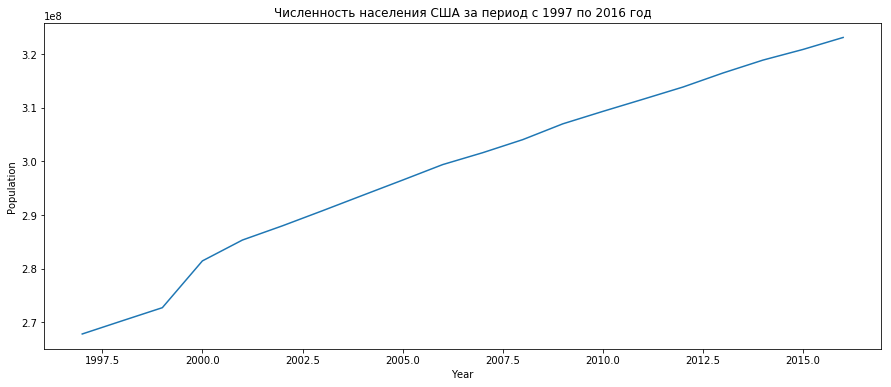

In [12]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Population')
plt.xlabel('Year')
plt.title('Численность населения США за период с 1997 по 2016 год')

plt.plot(crimes_data['Year'],
         crimes_data['Population'])

Восходящий тренд, практически линейная зависимость.

Относительно резкий скачок в 2000 году.

Сезонности не наблюдается.

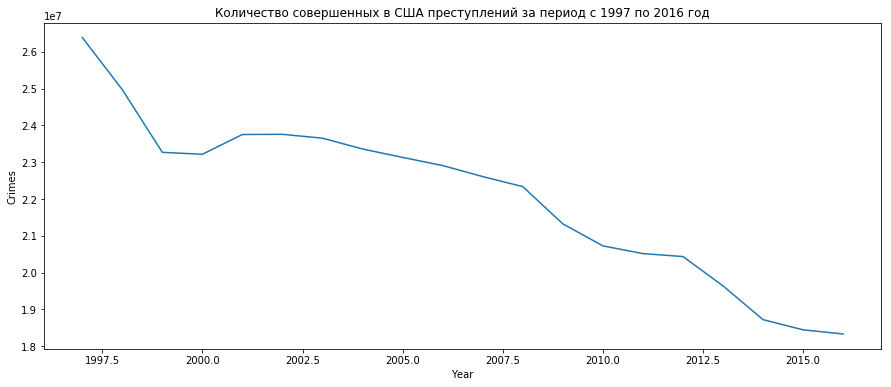

In [13]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Crimes')
plt.xlabel('Year')
plt.title('Количество совершенных в США преступлений за период с 1997 по 2016 год')

plt.plot(crimes_data['Year'],
         crimes_data['Crimes sum'])

Нисходящий тренд.

Скачки в 1999 и 2009 годах.

Сезонности не наблюдается.

### Проверка статистических гипотез

Проверим гипотезу (H0) о том, что в период 1997-2006 в среднем совершалось больше преступлений, чем в 2007-2016.

Применим критерий Манна-Уитни. Он применим, т.к. выборки независимы, все элементы в выборках различны, в каждой выборке более 3 элементов. Будем принемать нулевую гипотезу при p > 0.05.

In [14]:
scipy.stats.mannwhitneyu(crimes_data['Crimes sum'][10:],
                         crimes_data['Crimes sum'][:10],
                         alternative = 'greater')

MannwhitneyuResult(statistic=0.0, pvalue=0.9999325785388228)

Нулевая гипотеза принемается.

Выдвигаю предположение, что количество совершенных преступлений зависит от численности населения, чем больше население, тем больше преступлений.

Проверим две эти величины на коррелируемость. Посчитаем коэффициент корреляции Спирмена и его значимость. Он применим, т.к. общее число наблюдений в каждой из выборок > 5. Будем принемать нулевую гипотезу о том, что данные не коррелированы при p > 0.05.

In [15]:
scipy.stats.spearmanr(crimes_data['Population'],
                      crimes_data['Crimes sum'])

SpearmanrResult(correlation=-0.9624060150375938, pvalue=1.242702796593181e-11)

Нулевая гипотеза отвергается. Данные оказались коррелированы, но коэфициент корреляции почти -1. Видимо, сознательность населения и эффективность работы служб правопорядка в США растут быстрее, чем численность населения.

### Предсказание временного ряда

Построим прогнозы для численности населения и общего числа совершенных преступлений.

#### Численность населения

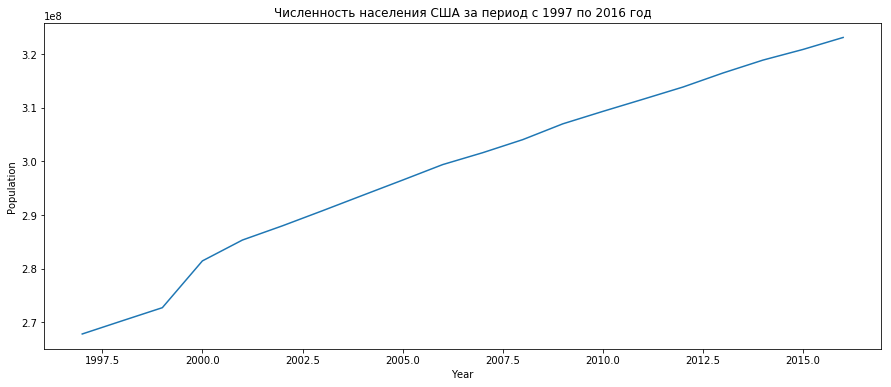

In [16]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Population')
plt.xlabel('Year')
plt.title('Численность населения США за период с 1997 по 2016 год')

plt.plot(crimes_data['Year'],
         crimes_data['Population'])

Зависимость нахожа на линейную, поэтому попробуем сделать прогноз с помощью линейной модели. Обучим её на данных начиная с 2000 года, так мы отбросим 3 наблюдения из 20, но зато необычный скачок в 2000 году не будет влиять на качество нашей модели. После 2000 года скачков нет.

In [17]:
train = pd.DataFrame()
train['Year'] = crimes_data['Year'][3:]
train['Population'] = crimes_data['Population'][3:]

In [18]:
train

,Year,Population
2000,2000.0,281421906.0
2001,2001.0,285317559.0
2002,2002.0,287973924.0
2003,2003.0,290788976.0
2004,2004.0,293656842.0
2005,2005.0,296507061.0
2006,2006.0,299398484.0
2007,2007.0,301621157.0
2008,2008.0,304059724.0
2009,2009.0,307006550.0


In [19]:
model = smf.ols('Population~Year', data=train)
fitted = model.fit()

In [20]:
train['Predicted'] = fitted.params[0] + fitted.params[1] * train['Year']

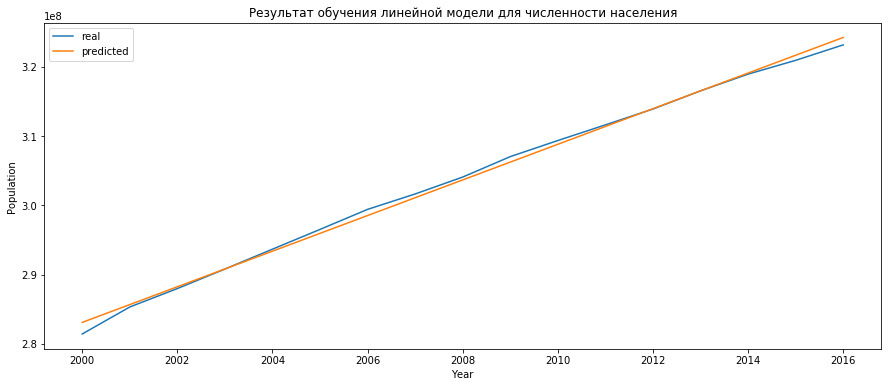

In [21]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Population')
plt.xlabel('Year')
plt.title('Результат обучения линейной модели для численности населения')

plt.plot(train['Year'],
         train['Population'], label='real')
plt.plot(train['Year'],
         train['Predicted'], label='predicted')

plt.legend()
plt.show()

In [22]:
fitted.rsquared

0.997283544722859

In [23]:
fitted.f_pvalue

1.1539894309138736e-20

Модель имеет хороший коэффициент детерминации и значима по критерию Фишера.

Сделаем прогноз на ближайшие 5 лет (относительно данных в датасете, т.е. года с 2017 по 2021) и сравним с реальными данными о численности населения США за 2017, 2018, 2019 года, взятыми из другого источника.

http://total-rating.ru/2003-chislennost-naseleniya-stran-mira-2017.html

https://yandex.ru/search/?text=%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D1%81%D1%88%D0%B0&lr=213

https://countrymeters.info/ru/United_States_Of_America_(USA)

In [24]:
years = np.arange(2016, 2022)
pred = fitted.params[0] + fitted.params[1] * years
real = np.array([323127513, 326625791, 327631340, 331281837])

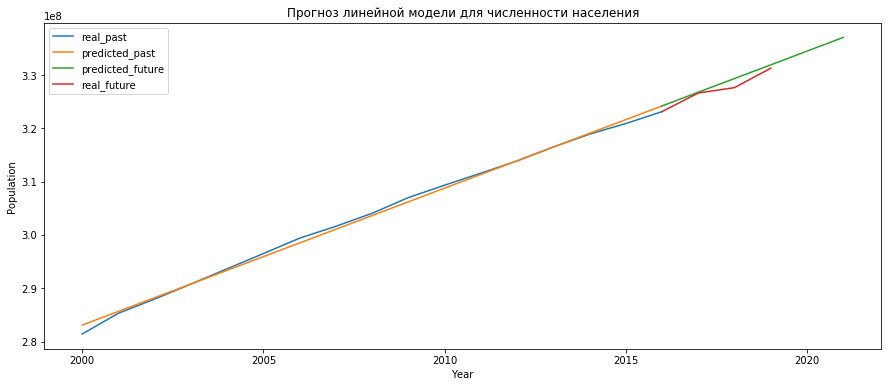

In [25]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Population')
plt.xlabel('Year')
plt.title('Прогноз линейной модели для численности населения')

plt.plot(train['Year'],
         train['Population'], label='real_past')
plt.plot(train['Year'],
         train['Predicted'], label='predicted_past')
plt.plot(years, pred, label='predicted_future')
plt.plot(years[:4], real, label='real_future')

plt.legend()
plt.show()

#### Количество совершенных преступлений

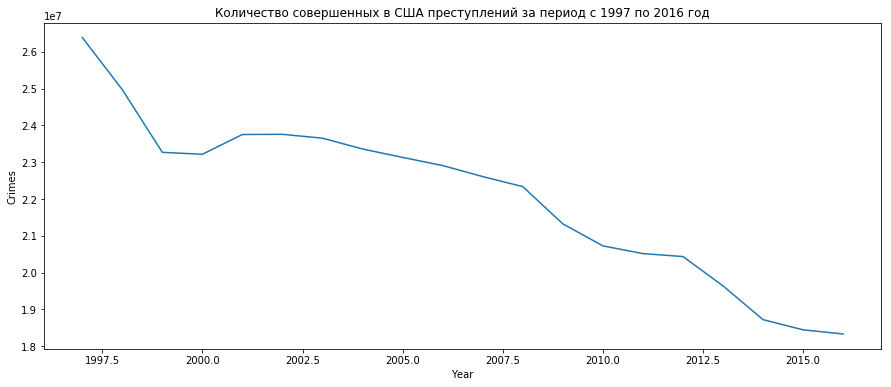

In [26]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Crimes')
plt.xlabel('Year')
plt.title('Количество совершенных в США преступлений за период с 1997 по 2016 год')

plt.plot(crimes_data['Year'],
         crimes_data['Crimes sum'])

Тренд

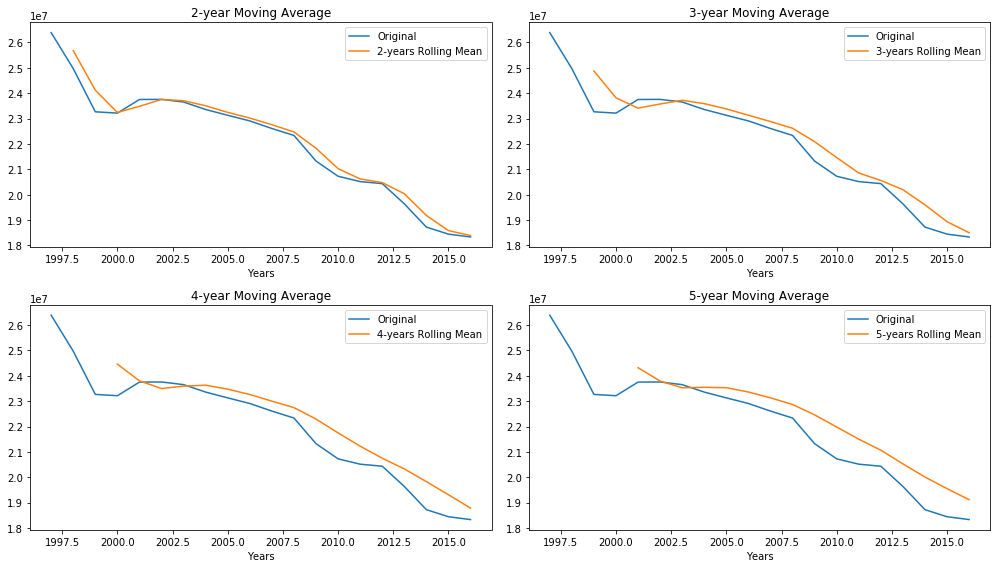

In [27]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(crimes_data['Year'],
                crimes_data['Crimes sum'], label='Original')
axes[0][0].plot(crimes_data['Year'],
                crimes_data['Crimes sum'].rolling(window=2).mean(),
                label='2-years Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_title("2-year Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(crimes_data['Year'],
                crimes_data['Crimes sum'], label='Original')
axes[0][1].plot(crimes_data['Year'],
                crimes_data['Crimes sum'].rolling(window=3).mean(),
                label='3-years Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_title("3-year Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(crimes_data['Year'],
                crimes_data['Crimes sum'], label='Original')
axes[1][0].plot(crimes_data['Year'],
                crimes_data['Crimes sum'].rolling(window=4).mean(),
                label='4-years Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_title("4-year Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(crimes_data['Year'],
                crimes_data['Crimes sum'], label='Original')
axes[1][1].plot(crimes_data['Year'],
                crimes_data['Crimes sum'].rolling(window=5).mean(),
                label='5-years Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_title("5-year Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

При всез размерах окон тренд практически совпадает с изначальным графиком. Сезонность не наблюдается.

Пробовал воспользоваться SARIMA, но не получается привести ряд к стационарному, поэтому снова воспользуемся линейной моделью.

In [28]:
train = pd.DataFrame()
train['Year'] = crimes_data['Year']
train['Crimes'] = crimes_data['Crimes sum']

In [29]:
train

,Year,Crimes
1997,1997.0,26389142.0
1998,1998.0,24971428.0
1999,1999.0,23268756.0
2000,2000.0,23216140.0
2001,2001.0,23753338.0
2002,2002.0,23757908.0
2003,2003.0,23653076.0
2004,2004.0,23358948.0
2005,2005.0,23130998.0
2006,2006.0,22909448.0


In [30]:
model = smf.ols('Crimes~Year', data=train)
fitted = model.fit()

In [31]:
train['Predicted'] = fitted.params[0] + fitted.params[1] * train['Year']

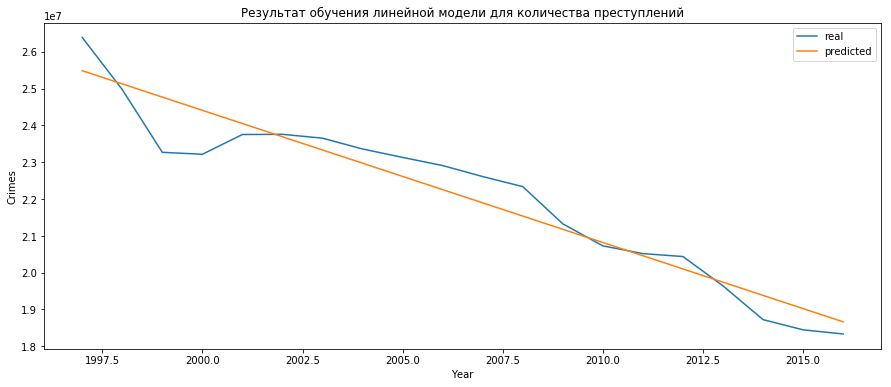

In [32]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Crimes')
plt.xlabel('Year')
plt.title('Результат обучения линейной модели для количества преступлений')

plt.plot(train['Year'],
         train['Crimes'], label='real')
plt.plot(train['Year'],
         train['Predicted'], label='predicted')

plt.legend()
plt.show()

In [33]:
fitted.rsquared

0.917247664300169

In [34]:
fitted.f_pvalue

3.508442343442357e-11

Модель имеет хороший коэффициент детерминации и значима по критерию Фишера.

Сделаем прогноз на ближайшие 5 лет.

In [35]:
years = np.arange(2016, 2022)
pred = fitted.params[0] + fitted.params[1] * years

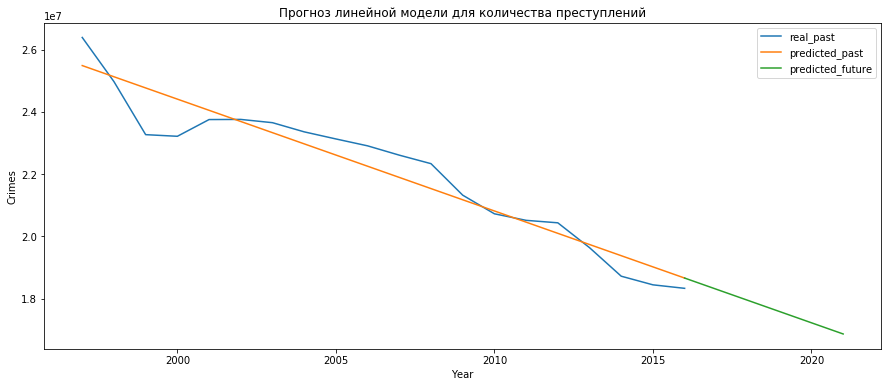

In [36]:
fig = plt.figure(figsize=(15, 6))
plt.ylabel('Crimes')
plt.xlabel('Year')
plt.title('Прогноз линейной модели для количества преступлений')

plt.plot(train['Year'],
         train['Crimes'], label='real_past')
plt.plot(train['Year'],
         train['Predicted'], label='predicted_past')
plt.plot(years, pred, label='predicted_future')

plt.legend()
plt.show()

### Выводы

Предположение о том, что количество совершенных преступлений растет вместе с численностью населения не оправдалось. Эта гипотеза не подтвердилась так на имеющихся данных, так и на прогнозе. Согласно ему количество совершенных в США преступлений будет уменьшаться, а численность населения расти.
Не использовал параметрические статистические критерии, т.к. не нашел данные попадающие под нормальное распределение.